In [9]:
import pandas as pd

df = pd.read_csv("dataset_clean/dev/dev_sent_emo.csv", sep=";", encoding="ISO-8859-1") 

print(df.head(5))


   Sr No.                                          Utterance   Speaker  \
0       1     Oh my God, hes lost it. Hes totally lost it.    Phoebe   
1       2                                              What?    Monica   
2       3  Or! Or, we could go to the bank, close our acc...      Ross   
3       4                                   Youre a genius!  Chandler   
4       5            Aww, man, now we wont be bank buddies!      Joey   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode StartTime  \
0   sadness  negative            0             0       4        7   20:57,3   
1  surprise  negative            0             1       4        7   21:01,9   
2   neutral   neutral            1             0       4        4   12:24,7   
3       joy  positive            1             1       4        4   12:32,3   
4   sadness  negative            1             2       4        4   12:34,2   

   EndTime  
0  21:00,0  
1  21:03,3  
2  12:30,9  
3  12:34,0  
4  12:37,5  


In [19]:
# Csv clean qui servira à fusionner avec les caractéristiques associés a chaque phrase
import pandas as pd

# Charger le CSV
df = pd.read_csv("dataset_clean/dev/dev_sent_emo.csv", sep=";", encoding="ISO-8859-1")

# Afficher les premières lignes pour vérifier la structure
print(df.head())

# Sélectionner les colonnes pertinentes pour la classification des émotions
df_relevant = df[['Emotion', 'Utterance']]

# Vérifier les valeurs uniques des émotions
#print(df_relevant['Emotion'].unique())

# Nettoyer les données 
df_relevant = df_relevant.dropna()  # Enlever les lignes avec des valeurs manquantes

# Affichage pour vérifier
print(df_relevant.head())


   Sr No.                                          Utterance   Speaker  \
0       1     Oh my God, hes lost it. Hes totally lost it.    Phoebe   
1       2                                              What?    Monica   
2       3  Or! Or, we could go to the bank, close our acc...      Ross   
3       4                                   Youre a genius!  Chandler   
4       5            Aww, man, now we wont be bank buddies!      Joey   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode StartTime  \
0   sadness  negative            0             0       4        7   20:57,3   
1  surprise  negative            0             1       4        7   21:01,9   
2   neutral   neutral            1             0       4        4   12:24,7   
3       joy  positive            1             1       4        4   12:32,3   
4   sadness  negative            1             2       4        4   12:34,2   

   EndTime  
0  21:00,0  
1  21:03,3  
2  12:30,9  
3  12:34,0  
4  12:37,5  
  

In [27]:
import opensmile
import os
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

# Charger le dataframe contenant les émotions
df = pd.read_csv("dataset_clean/dev/dev_sent_emo.csv", sep=";", encoding="ISO-8859-1")

# Créer un dataframe avec les émotions et les énoncés
df_relevant = df[['Emotion', 'Utterance']].dropna()

# Afficher les émotions uniques
print(df_relevant['Emotion'].unique())  # Vérifier toutes les émotions disponibles

# Définir le chemin du dossier contenant les audios
audio_folder = "dataset_clean/dev/audios/"
audio_files = sorted(os.listdir(audio_folder))  # Trier les fichiers pour éviter le désordre

# Sélectionner les 30 premiers fichiers audio
audio_files = audio_files[:30]  # Limiter à 30 fichiers pour l'exemple

# Créer un objet OpenSMILE avec une configuration valide
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,  # Configuration pour ComParE_2016
    feature_level=opensmile.FeatureLevel.Functionals  # Niveau des fonctionnalités (moyennes, std, etc.)
)

# Initialiser le LabelEncoder pour convertir les étiquettes d'émotions en entiers
label_encoder = LabelEncoder()
label_encoder.fit(df_relevant['Emotion'].unique())  # Apprendre les étiquettes d'émotions

# Extraire les caractéristiques audio et les émotions associées aux fichiers
X = []
y = []

for i, audio_file in enumerate(audio_files):
    audio_path = os.path.join(audio_folder, audio_file)
    
    # Extraire les caractéristiques du fichier audio
    features = smile.process_file(audio_path)
    
    # Réinitialiser l'index pour enlever les niveaux multiples de MultiIndex
    features_reset = features.reset_index()
    
    # Convertir les caractéristiques en tableau NumPy
    features_array = features_reset.drop(['file', 'start', 'end'], axis=1).values
    
    # Ajouter les caractéristiques à la liste X
    X.append(features_array.flatten())  # Aplatir le tableau pour obtenir une ligne unique
    
    # Extraire l'émotion associée à ce fichier audio depuis le dataframe df_relevant
    emotion = df_relevant.iloc[i]['Emotion']
    
    # Ajouter l'émotion à la liste y après transformation en entier
    y.append(label_encoder.transform([emotion])[0])

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Calculer n_components de manière dynamique pour qu'il soit valide
n_classes = len(np.unique(y))  # Nombre d'émotions uniques
n_features = X.shape[1]  # Nombre de caractéristiques extraites

# S'assurer que n_components respecte la contrainte
n_components = min(7, n_classes - 1, n_features)

# Appliquer LDA (Linear Discriminant Analysis)
lda = LinearDiscriminantAnalysis(n_components=n_components)  # Utiliser le nombre approprié de composantes
lda.fit(X, y)  # Entraîner LDA sur les caractéristiques et les émotions

# Appliquer LDA sur les caractéristiques des 30 audios
X_lda = lda.transform(X)

# Afficher les caractéristiques réduites
print(f"Caractéristiques réduites après LDA : {X_lda}")


['sadness' 'surprise' 'neutral' 'joy' 'anger' 'disgust' 'fear']
Caractéristiques réduites après LDA : [[ 0.18763058 -0.45991126  0.22325307 -0.23112148]
 [ 0.61695606  1.7807293   0.07349628 -0.5387007 ]
 [ 0.97496253  0.87585413  0.61407363  0.3491623 ]
 [-2.9130845  -1.9372734  -0.8272921  -0.37198082]
 [ 0.5450134   0.21629457  1.2250175  -1.2241772 ]
 [ 1.1822509  -0.3264495   0.42009994 -1.5783043 ]
 [ 0.16136906 -0.3068881   0.316715   -0.9728636 ]
 [ 1.3389541  -0.96485937  0.2635329  -0.11932697]
 [ 0.1243787  -0.64978665  0.3897693   2.1538372 ]
 [-0.30290645  0.03140395 -1.1268449  -0.02998139]
 [-0.9182137   1.0929157  -0.8672093   0.1082748 ]
 [ 0.10158342  0.29726806  0.34089446 -0.08554813]
 [ 0.12234323 -0.7476404  -0.20410486 -2.4143047 ]
 [ 0.44068125 -0.48721322  1.2223823   0.90177816]
 [ 0.2642201   0.18513437 -1.6184535   0.17966986]
 [-0.6521063  -0.818561    2.2238228   1.097779  ]
 [ 1.3531508   0.00417111 -1.6129218   1.0307841 ]
 [ 0.8640672  -1.8942351   0.45

In [32]:
import opensmile
import os
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

# Charger le dataframe contenant les émotions
df = pd.read_csv("dataset_clean/dev/dev_sent_emo.csv", sep=";", encoding="ISO-8859-1")

# Créer un dataframe avec les émotions et les énoncés
df_relevant = df[['Emotion', 'Utterance']].dropna()

# Afficher les émotions uniques
print(df_relevant['Emotion'].unique())  # Vérifier toutes les émotions disponibles

# Définir le chemin du dossier contenant les audios
audio_folder = "dataset_clean/dev/audios/"
audio_files = sorted(os.listdir(audio_folder))  # Trier les fichiers pour éviter le désordre

# Sélectionner les 30 premiers fichiers audio
audio_files = audio_files[:100]  # Limiter à 30 fichiers pour l'exemple

# Créer un objet OpenSMILE avec une configuration valide
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,  # Configuration pour ComParE_2016
    feature_level=opensmile.FeatureLevel.Functionals  # Niveau des fonctionnalités (moyennes, std, etc.)
)

# Initialiser le LabelEncoder pour convertir les étiquettes d'émotions en entiers
label_encoder = LabelEncoder()
label_encoder.fit(df_relevant['Emotion'].unique())  # Apprendre les étiquettes d'émotions

# Extraire les caractéristiques audio et les émotions associées aux fichiers
X = []
y = []

for i, audio_file in enumerate(audio_files):
    audio_path = os.path.join(audio_folder, audio_file)
    
    # Extraire les caractéristiques du fichier audio
    features = smile.process_file(audio_path)
    
    # Réinitialiser l'index pour enlever les niveaux multiples de MultiIndex
    features_reset = features.reset_index()
    
    # Convertir les caractéristiques en tableau NumPy
    features_array = features_reset.drop(['file', 'start', 'end'], axis=1).values
    
    # Ajouter les caractéristiques à la liste X
    X.append(features_array.flatten())  # Aplatir le tableau pour obtenir une ligne unique
    
    # Extraire l'émotion associée à ce fichier audio depuis le dataframe df_relevant
    emotion = df_relevant.iloc[i]['Emotion']
    
    # Ajouter l'émotion à la liste y après transformation en entier
    y.append(label_encoder.transform([emotion])[0])

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Calculer n_components de manière dynamique pour qu'il soit valide
n_classes = len(np.unique(y))  # Nombre d'émotions uniques
n_features = X.shape[1]  # Nombre de caractéristiques extraites

# S'assurer que n_components respecte la contrainte
n_components = min(7, n_classes - 1, n_features)

# Appliquer LDA (Linear Discriminant Analysis)
lda = LinearDiscriminantAnalysis(n_components=n_components)  # Utiliser le nombre approprié de composantes
lda.fit(X, y)  # Entraîner LDA sur les caractéristiques et les émotions

# Appliquer LDA sur les caractéristiques des 30 audios
X_lda = lda.transform(X)

# Affichage des caractéristiques réduites avec les émotions associées
for i in range(len(X_lda)):
    emotion = label_encoder.inverse_transform([y[i]])[0]  # Convertir le label numérique en émotion
    print(f"Emotion: {emotion}")
    print(f"Caractéristiques réduites: {X_lda[i]}")
    print()


['sadness' 'surprise' 'neutral' 'joy' 'anger' 'disgust' 'fear']
Emotion: sadness
Caractéristiques réduites: [-0.30892056  2.10776     0.9194853  -0.28072807  1.2371045 ]

Emotion: surprise
Caractéristiques réduites: [ 2.4576268  -1.1618607   0.41829222 -0.04484646  1.7159926 ]

Emotion: neutral
Caractéristiques réduites: [ 0.7509518   1.0920172  -0.5552484  -0.18605778 -1.48224   ]

Emotion: joy
Caractéristiques réduites: [-0.9777862  1.1477978 -3.5388823 -1.0706334  1.6620737]

Emotion: sadness
Caractéristiques réduites: [ 0.03864503 -1.4026675  -1.4354233   0.5754132   0.00469244]

Emotion: neutral
Caractéristiques réduites: [-0.20707542  0.1900329   0.9090919   2.0996726  -1.029223  ]

Emotion: neutral
Caractéristiques réduites: [ 0.10032827 -0.01784578  0.24079958 -0.28250873  0.03867029]

Emotion: joy
Caractéristiques réduites: [-1.3532248   0.609839   -0.39796513  0.26085073  0.9469808 ]

Emotion: neutral
Caractéristiques réduites: [-0.3056341  -0.35666713 -0.8093043  -0.5295357 

In [30]:
import opensmile
import os
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

# Charger le dataframe contenant les émotions
df = pd.read_csv("dataset_clean/dev/dev_sent_emo.csv", sep=";", encoding="ISO-8859-1")

# Créer un dataframe avec les émotions et les énoncés
df_relevant = df[['Emotion', 'Utterance']].dropna()

# Définir le chemin du dossier contenant les audios
audio_folder = "dataset_clean/dev/audios/"
audio_files = sorted(os.listdir(audio_folder))  # Trier les fichiers pour éviter le désordre

# Sélectionner les 100 premiers fichiers audio
audio_files = audio_files[:100]  # Limiter à 100 fichiers pour l'exemple

# Créer un objet OpenSMILE avec une configuration valide
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,  # Configuration pour ComParE_2016
    feature_level=opensmile.FeatureLevel.Functionals  # Niveau des fonctionnalités (moyennes, std, etc.)
)

# Initialiser le LabelEncoder pour convertir les étiquettes d'émotions en entiers
label_encoder = LabelEncoder()
label_encoder.fit(df_relevant['Emotion'].unique())  # Apprendre les étiquettes d'émotions

# Extraire les caractéristiques audio et les émotions associées aux fichiers
X = []
y = []

for i, audio_file in enumerate(audio_files):
    audio_path = os.path.join(audio_folder, audio_file)
    
    # Extraire les caractéristiques du fichier audio
    features = smile.process_file(audio_path)
    
    # Réinitialiser l'index pour enlever les niveaux multiples de MultiIndex
    features_reset = features.reset_index()
    
    # Convertir les caractéristiques en tableau NumPy
    features_array = features_reset.drop(['file', 'start', 'end'], axis=1).values
    
    # Ajouter les caractéristiques à la liste X
    X.append(features_array.flatten())  # Aplatir le tableau pour obtenir une ligne unique
    
    # Extraire l'émotion associée à ce fichier audio depuis le dataframe df_relevant
    emotion = df_relevant.iloc[i]['Emotion']
    
    # Ajouter l'émotion à la liste y après transformation en entier
    y.append(label_encoder.transform([emotion])[0])

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Calculer n_components de manière dynamique pour qu'il soit valide
n_classes = len(np.unique(y))  # Nombre d'émotions uniques
n_features = X.shape[1]  # Nombre de caractéristiques extraites

# S'assurer que n_components respecte la contrainte
n_components = min(7, n_classes - 1, n_features)

# Appliquer LDA (Linear Discriminant Analysis)
lda = LinearDiscriminantAnalysis(n_components=n_components)  # Utiliser le nombre approprié de composantes
lda.fit(X, y)  # Entraîner LDA sur les caractéristiques et les émotions

# Appliquer LDA sur les caractéristiques des 100 audios
X_lda = lda.transform(X)

# Calculer la moyenne des caractéristiques pour chaque émotion
emotion_medians = {}
for emotion in label_encoder.classes_:
    # Récupérer les indices des fichiers audio associés à chaque émotion
    emotion_indices = np.where(y == label_encoder.transform([emotion])[0])[0]
    
    # Extraire les caractéristiques LDA des fichiers audio associés à l'émotion
    emotion_features = X_lda[emotion_indices]
    
    # Calculer la moyenne des caractéristiques pour cette émotion
    emotion_medians[emotion] = np.mean(emotion_features, axis=0)

# Afficher la moyenne des caractéristiques réduites par émotion
for emotion, mean in emotion_medians.items():
    print(f"Moyenne des caractéristiques pour l'émotion '{emotion}': {mean}")


Moyenne des caractéristiques pour l'émotion 'anger': [ 0.7829712   0.76572126 -0.14205004  0.55117667 -0.47953346]
Moyenne des caractéristiques pour l'émotion 'disgust': [-0.09785099  1.9437783   2.34578     1.7206297   3.0992537 ]
Moyenne des caractéristiques pour l'émotion 'fear': [nan nan nan nan nan]
Moyenne des caractéristiques pour l'émotion 'joy': [-0.21058139  0.11475594 -1.1898345  -0.12048624  0.46441406]
Moyenne des caractéristiques pour l'émotion 'neutral': [-0.63854116  0.00381264  0.25352693 -0.15068047 -0.11287099]
Moyenne des caractéristiques pour l'émotion 'sadness': [-0.18593472 -1.8733537  -0.13350868  1.7160416  -0.00864312]
Moyenne des caractéristiques pour l'émotion 'surprise': [ 1.2608408  -0.42920962  0.26707733 -0.44072157  0.16912955]


C:\Users\boucceredj\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\boucceredj\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [31]:
import opensmile
import os
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Charger le dataframe contenant les émotions
df = pd.read_csv("dataset_clean/dev/dev_sent_emo.csv", sep=";", encoding="ISO-8859-1")

# Définir le chemin du dossier contenant les audios
audio_folder = "dataset_clean/dev/audios/"
audio_files = sorted(os.listdir(audio_folder))  # Trier les fichiers pour éviter le désordre

# Sélectionner les 30 premiers fichiers audio
audio_files = audio_files[:30]  # Limiter à 30 fichiers pour l'exemple

# Créer un objet OpenSMILE avec une configuration valide
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,  # Configuration pour ComParE_2016
    feature_level=opensmile.FeatureLevel.Functionals  # Niveau des fonctionnalités (moyennes, std, etc.)
)

# Extraire les caractéristiques audio et les émotions associées aux fichiers
X = []
y = []

for i, audio_file in enumerate(audio_files):
    audio_path = os.path.join(audio_folder, audio_file)
    
    # Extraire les caractéristiques du fichier audio
    features = smile.process_file(audio_path)
    
    # Réinitialiser l'index pour enlever les niveaux multiples de MultiIndex
    features_reset = features.reset_index()
    
    # Convertir les caractéristiques en tableau NumPy
    features_array = features_reset.drop(['file', 'start', 'end'], axis=1).values
    
    # Ajouter les caractéristiques à la liste X
    X.append(features_array.flatten())  # Aplatir le tableau pour obtenir une ligne unique
    
    # Extraire l'émotion associée à ce fichier audio depuis le dataframe df
    # Assumer que les fichiers audio sont triés de manière correspondante avec le dataframe
    emotion = df.iloc[i]['Emotion']
    
    # Ajouter l'émotion à la liste y
    y.append(emotion)

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Appliquer LDA (Linear Discriminant Analysis)
lda = LinearDiscriminantAnalysis(n_components=7)  # Utiliser 2 composantes pour la réduction
lda.fit(X, y)  # Entraîner LDA sur les caractéristiques et les émotions

# Appliquer LDA sur les caractéristiques des 30 audios
X_lda = lda.transform(X)

# Afficher les caractéristiques réduites
print(f"Caractéristiques réduites après LDA : {X_lda}")


ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

In [10]:
import opensmile
from sklearn.decomposition import PCA
import pandas as pd

# Initialiser openSMILE avec les paramètres désirés
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,  # Jeu de caractéristiques
    feature_level=opensmile.FeatureLevel.Functionals,  # Niveau des fonctionnalités
)

# Traiter un fichier audio
audio_features = smile.process_file('train/train_audio/your_audio.wav')

# Convertir les caractéristiques extraites en DataFrame pour une manipulation facile
audio_features_df = pd.DataFrame(audio_features)

# Afficher la forme des données (nombre de lignes et de colonnes)
print(f"Forme des données extraites : {audio_features_df.shape}")

# Vérifier le nombre de lignes et de colonnes
n_samples, n_features = audio_features_df.shape

# Appliquer PCA en fonction du nombre de samples
n_components = min(2, n_features)  # Si n_samples = 1, on applique PCA à 2 composants max, sinon à min(100, n_features)
print(f"Nombre de composantes pour PCA : {n_components}")

# Appliquer PCA pour réduire la dimensionnalité
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(audio_features_df)

# Créer un DataFrame avec les caractéristiques réduites
reduced_features_df = pd.DataFrame(reduced_features)

# Afficher les premières lignes des caractéristiques réduites
print(f"Caractéristiques après réduction de dimension :")
print(reduced_features_df.head())

# Optionnel : Enregistrer les caractéristiques réduites dans un fichier CSV
#reduced_features_df.to_csv('reduced_audio_features.csv', index=False)


LibsndfileError: Error opening 'C:\\Users\\boucceredj\\Desktop\\Master_IISC_2eme_annee\\projet_synthese\\notreChoix\\code\\train\\train_audio\\your_audio.wav': System error.

In [ ]:
import subprocess
import os

# Chemin vers l'exécutable OpenSMILE
smile_exec_path = "path_to_opensmile/SMILExtract"  # Remplace par le chemin exact vers SMILExtract

# Chemin vers le fichier de configuration eGeMAPS
config_path = "path_to_opensmile/config/gemaps/eGeMAPSv02.conf"

# Dossier contenant les fichiers audio
audio_folder = "path_to_audio_files"
output_folder = "path_to_output_files"

# Créer le dossier de sortie s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

# Parcourir les fichiers audio dans le dossier
for audio_file in os.listdir(audio_folder):
    if audio_file.endswith(".wav") or audio_file.endswith(".mp3"):
        input_audio_path = os.path.join(audio_folder, audio_file)
        output_csv_path = os.path.join(output_folder, audio_file.replace(".wav", ".csv").replace(".mp3", ".csv"))

        print(f"Traitement de {audio_file}...")

        # Commande OpenSMILE
        command = [
            smile_exec_path,
            "-C", config_path,               # Configuration eGeMAPS
            "-I", input_audio_path,          # Fichier audio en entrée
            "-O", output_csv_path            # Fichier CSV en sortie
        ]

        # Exécuter la commande
        try:
            subprocess.run(command, check=True)
            print(f"Fichier traité avec succès : {output_csv_path}")
        except subprocess.CalledProcessError as e:
            print(f"Erreur lors du traitement de {audio_file} : {e}")


In [13]:
import opensmile

# Afficher les configurations disponibles dans FeatureSet
print(list(opensmile.FeatureSet))


[<FeatureSet.ComParE_2016: 'compare/ComParE_2016'>, <FeatureSet.GeMAPS: 'gemaps/v01a/GeMAPSv01a'>, <FeatureSet.GeMAPSv01b: 'gemaps/v01b/GeMAPSv01b'>, <FeatureSet.eGeMAPS: 'egemaps/v01a/eGeMAPSv01a'>, <FeatureSet.eGeMAPSv01b: 'egemaps/v01b/eGeMAPSv01b'>, <FeatureSet.eGeMAPSv02: 'egemaps/v02/eGeMAPSv02'>, <FeatureSet.emobase: 'emobase/emobase'>]


In [20]:
import opensmile
import os

# Définir le chemin du dossier contenant les audios
audio_folder = "dataset_clean/dev/audios/"
audio_files = sorted(os.listdir(audio_folder))  # Trier les fichiers pour éviter le désordre
first_audio = os.path.join(audio_folder, audio_files[0])  # Prendre le premier fichier

# Créer un objet OpenSMILE avec une configuration valide
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,  # Configuration pour ComParE_2016
    feature_level=opensmile.FeatureLevel.Functionals  # Niveau des fonctionnalités (moyennes, std, etc.)
)

# Extraire les caractéristiques audio du premier fichier
features = smile.process_file(first_audio)

# Afficher les caractéristiques dans la console
# Afficher les premières lignes du DataFrame sans index multi-niveau
# Réinitialiser l'index pour enlever les niveaux multiples
features_reset = features.reset_index()

# Afficher les premières lignes de manière plus lisible
print(features_reset.head())  # Affiche les 5 premières lignes du DataFrame
print(f"Extraction terminée pour : {first_audio}")


                                     file  start                       end  \
0  dataset_clean/dev/audios/dia0_utt0.wav 0 days 0 days 00:00:02.794666667   

   audspec_lengthL1norm_sma_range  audspec_lengthL1norm_sma_maxPos  \
0                        1.893929                         0.220588   

   audspec_lengthL1norm_sma_minPos  audspec_lengthL1norm_sma_quartile1  \
0                         0.172794                            0.706538   

   audspec_lengthL1norm_sma_quartile2  audspec_lengthL1norm_sma_quartile3  \
0                            1.049367                            1.491009   

   audspec_lengthL1norm_sma_iqr1-2  ...  mfcc_sma_de[14]_peakRangeAbs  \
0                          0.34283  ...                       6.21958   

   mfcc_sma_de[14]_peakRangeRel  mfcc_sma_de[14]_peakMeanAbs  \
0                      0.612551                     2.319552   

   mfcc_sma_de[14]_peakMeanMeanDist  mfcc_sma_de[14]_peakMeanRel  \
0                          2.281682                   

In [22]:
import opensmile
import os
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Définir le chemin du dossier contenant les audios
audio_folder = "dataset_clean/dev/audios/"
audio_files = sorted(os.listdir(audio_folder))  # Trier les fichiers pour éviter le désordre
first_audio = os.path.join(audio_folder, audio_files[0])  # Prendre le premier fichier
second_audio = os.path.join(audio_folder, audio_files[1])  # Prendre le deuxième fichier

# Créer un objet OpenSMILE avec une configuration valide
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,  # Configuration pour ComParE_2016
    feature_level=opensmile.FeatureLevel.Functionals  # Niveau des fonctionnalités (moyennes, std, etc.)
)

# Extraire les caractéristiques audio du premier et deuxième fichier
features_first = smile.process_file(first_audio)
features_second = smile.process_file(second_audio)

# Réinitialiser l'index pour enlever les niveaux multiples de MultiIndex
features_first_reset = features_first.reset_index()
features_second_reset = features_second.reset_index()

# Convertir les caractéristiques en matrices NumPy pour LDA
X_first_audio = features_first_reset.drop(['file', 'start', 'end'], axis=1).values
X_second_audio = features_second_reset.drop(['file', 'start', 'end'], axis=1).values

# Ajouter les deux échantillons (pour que LDA puisse fonctionner)
X = np.vstack([X_first_audio, X_second_audio])

# Étiquettes correspondantes pour chaque audio (par exemple, 'sadness' pour le premier et 'joy' pour le deuxième)
y = np.array(['sadness', 'joy'])

# Appliquer LDA
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X, y)  # Entraîner LDA sur les deux premiers échantillons

# Appliquer LDA sur les caractéristiques des deux audios
X_lda = lda.transform(X)

# Afficher les caractéristiques réduites
print(f"Caractéristiques réduites après LDA : {X_lda}")


ValueError: The number of samples must be more than the number of classes.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Supposons que `df_features` contient tes données extraites et `labels` contient les étiquettes émotionnelles
X = df_features.drop('emotion_label', axis=1)  # X : toutes les caractéristiques sauf l'étiquette émotionnelle
y = df_features['emotion_label']  # y : les étiquettes émotionnelles

# Scaler les données (facultatif mais recommandé pour certains modèles)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparer en train et test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modèle RandomForest pour obtenir l'importance des caractéristiques
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Affichage de l'importance des caractéristiques
feature_importances = rf.feature_importances_
important_features = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

print(important_features[:10])  # Affiche les 10 caractéristiques les plus importantes


NameError: name 'df_features' is not defined

In [2]:
# LDA pour emotion + sentiment
import os
import re
import pandas as pd
import opensmile
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Chemin du dossier principal
dataset_path = "dataset_clean"

# Dossiers à traiter
folders = ["dev", "train", "test"]

# Pour chaque dossier
for folder in folders:
    print(f"\nTraitement du dossier {folder}...")
    
    # Charger le CSV filtré avec les labels
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lors de la lecture de {csv_path} : {e}")
        continue

    # Dossier des audios
    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Le dossier des audios n'existe pas : {audios_dir}")
        continue

    features_list = []

    # Initialiser opensmile (ici avec ComParE_2016 et niveau Functionals)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals
    )
    
    file_count = 0
    
    # Parcourir les fichiers audio
    for file in os.listdir(audios_dir):
        if file.lower().endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            
            # Extraire dialogue_id et utterance_id à partir du nom de fichier
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                print(f"Nom de fichier non conforme : {file}")
                continue
            dialogue_id = int(match.group(1))
            utterance_id = int(match.group(2))
            
            try:
                # Extraction des caractéristiques avec opensmile
                features_df = smile.process_file(audio_path)
            except Exception as e:
                print(f"Erreur lors de l'extraction pour {file} : {e}")
                continue

            # On récupère la première (et unique) ligne des features extraites
            feat_dict = features_df.iloc[0].to_dict()
            # print(f"Nombre de caractéristiques extraites : {len(feat_dict)}") #la raison pour laquelle on utilise lda
            feat_dict["Dialogue_ID"] = dialogue_id
            feat_dict["Utterance_ID"] = utterance_id
            
            # Récupérer les labels correspondant à ce fichier
            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dialogue_id) &
                (labels_df["Utterance_ID"] == utterance_id)
            ].iloc[0]  # On prend directement la première ligne correspondante

            feat_dict["Emotion"] = label_row["Emotion"]
            feat_dict["Sentiment"] = label_row["Sentiment"]
            
            features_list.append(feat_dict)
            
            # Incrémenter le compteur
            file_count += 1

            # Afficher tous les 100 fichiers traités
            if file_count % 100 == 0:
                print(f"Progression : {file_count} fichiers traités")
    
    # Créer un DataFrame avec toutes les caractéristiques
    if not features_list:
        print(f"Aucun fichier audio traité dans {audios_dir}")
        continue
    features_all = pd.DataFrame(features_list)
    
    # Créer une colonne "Label" qui combine Emotion et Sentiment si possible
    def combine_labels(row):
        if pd.notnull(row["Emotion"]) and pd.notnull(row["Sentiment"]):
            return f"{row['Emotion']}_{row['Sentiment']}"
        else:
            return row["Emotion"]
    
    features_all["Label"] = features_all.apply(combine_labels, axis=1)
    
    # Sélectionner les colonnes de features (exclure les colonnes non-numériques et les labels)
    exclude_cols = ["Dialogue_ID", "Utterance_ID", "Emotion", "Sentiment", "Label"]
    feature_cols = [col for col in features_all.columns if col not in exclude_cols]
    
    X = features_all[feature_cols].values
    y = features_all["Label"].values

    # Appliquer LDA si plusieurs classes sont présentes (LDA est supervisé)
    unique_labels = set(y)
    if len(unique_labels) > 1:
        n_components = min(len(unique_labels) - 1, X.shape[1])
        lda = LDA(n_components=n_components)
        try:
            X_reduced = lda.fit_transform(X, y)
            # Ajouter les composantes réduites au DataFrame
            for i in range(X_reduced.shape[1]):
                features_all[f"LDA_{i+1}"] = X_reduced[:, i]
        except Exception as e:
            print(f"Erreur lors de LDA pour le dossier {folder} : {e}")
    else:
        print(f"Pas assez de classes pour appliquer LDA dans le dossier {folder}.")

    # Enregistrer le DataFrame avec les caractéristiques dans un CSV
    output_csv = os.path.join(dataset_path, folder, f"features_{folder}.csv")
    features_all.to_csv(output_csv, index=False)
    print(f"Fichier des caractéristiques sauvegardé : {output_csv}")



Traitement du dossier train...
Progression : 100 fichiers traités


KeyboardInterrupt: 

In [5]:
#LDA pour emotion only
import os
import re
import pandas as pd
import opensmile
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Chemin du dossier principal
dataset_path = "dataset_clean"

# Dossiers à traiter
folders = ["dev", "train", "test"]

# Pour chaque dossier
for folder in folders:
    print(f"\nTraitement du dossier {folder}...")
    
    # Charger le CSV filtré avec les labels
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lors de la lecture de {csv_path} : {e}")
        continue

    # Dossier des audios
    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Le dossier des audios n'existe pas : {audios_dir}")
        continue

    features_list = []

    # Initialiser opensmile (ici avec ComParE_2016 et niveau Functionals)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals
    )
    
    file_count = 0
    
    # Parcourir les fichiers audio
    for file in os.listdir(audios_dir):
        if file.lower().endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            
            # Extraire dialogue_id et utterance_id à partir du nom de fichier
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                print(f"Nom de fichier non conforme : {file}")
                continue
            dialogue_id = int(match.group(1))
            utterance_id = int(match.group(2))
            
            try:
                # Extraction des caractéristiques avec opensmile
                features_df = smile.process_file(audio_path)
            except Exception as e:
                print(f"Erreur lors de l'extraction pour {file} : {e}")
                continue

            # On récupère la première (et unique) ligne des features extraites
            feat_dict = features_df.iloc[0].to_dict()
            feat_dict["Dialogue_ID"] = dialogue_id
            feat_dict["Utterance_ID"] = utterance_id
            
            # Récupérer le label d'Emotion correspondant à ce fichier
            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dialogue_id) &
                (labels_df["Utterance_ID"] == utterance_id)
            ].iloc[0]  # On prend directement la première ligne correspondante

            feat_dict["Emotion"] = label_row["Emotion"]
            
            features_list.append(feat_dict)
            
            # Incrémenter le compteur
            file_count += 1

            # Afficher tous les 100 fichiers traités
            if file_count % 100 == 0:
                print(f"Progression : {file_count} fichiers traités")
    
    # Créer un DataFrame avec toutes les caractéristiques
    if not features_list:
        print(f"Aucun fichier audio traité dans {audios_dir}")
        continue
    features_all = pd.DataFrame(features_list)
    
    # Sélectionner les colonnes de features (exclure les colonnes non-numériques et le label Emotion)
    exclude_cols = ["Dialogue_ID", "Utterance_ID", "Emotion"]
    feature_cols = [col for col in features_all.columns if col not in exclude_cols]
    
    X = features_all[feature_cols].values
    y = features_all["Emotion"].values  # On utilise uniquement Emotion comme cible

    # Appliquer LDA si plusieurs émotions sont présentes (LDA est supervisé)
    unique_emotions = set(y)
    if len(unique_emotions) > 1:
        n_components = min(len(unique_emotions) - 1, X.shape[1])  # Le nombre de composantes est min(émotions - 1, caractéristiques)
        lda = LDA(n_components=n_components)
        try:
            X_reduced = lda.fit_transform(X, y)
            # Ajouter les composantes réduites au DataFrame
            for i in range(X_reduced.shape[1]):
                features_all[f"LDA_{i+1}"] = X_reduced[:, i]
        except Exception as e:
            print(f"Erreur lors de LDA pour le dossier {folder} : {e}")
    else:
        print(f"Pas assez de classes pour appliquer LDA dans le dossier {folder}.")

    # Filtrer les colonnes pour ne garder que les caractéristiques (et Emotion)
    columns_to_keep = ["Emotion"] + [f"LDA_{i+1}" for i in range(X_reduced.shape[1])]
    features_all = features_all[columns_to_keep]

    # Enregistrer le DataFrame avec les caractéristiques dans un CSV
    output_csv = os.path.join(dataset_path, folder, f"features_{folder}_emotion.csv")
    features_all.to_csv(output_csv, index=False)
    print(f"Fichier des caractéristiques sauvegardé : {output_csv}")



Traitement du dossier dev...
Progression : 100 fichiers traités
Progression : 200 fichiers traités
Progression : 300 fichiers traités
Progression : 400 fichiers traités
Progression : 500 fichiers traités
Progression : 600 fichiers traités
Progression : 700 fichiers traités
Progression : 800 fichiers traités
Progression : 900 fichiers traités
Progression : 1000 fichiers traités
Progression : 1100 fichiers traités
Fichier des caractéristiques sauvegardé : dataset_clean\dev\features_dev_emotion.csv

Traitement du dossier train...
Progression : 100 fichiers traités
Progression : 200 fichiers traités
Progression : 300 fichiers traités
Progression : 400 fichiers traités
Progression : 500 fichiers traités
Progression : 600 fichiers traités
Progression : 700 fichiers traités
Progression : 800 fichiers traités
Progression : 900 fichiers traités
Progression : 1000 fichiers traités
Progression : 1100 fichiers traités
Progression : 1200 fichiers traités
Progression : 1300 fichiers traités
Progres

In [ ]:
# LDA pour sentiment only 
import os
import re
import pandas as pd
import opensmile
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Chemin du dossier principal
dataset_path = "dataset_clean"

# Dossiers à traiter
folders = ["train", "dev", "test"]

# Pour chaque dossier
for folder in folders:
    print(f"\nTraitement du dossier {folder}...")
    
    # Charger le CSV filtré avec les labels
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lors de la lecture de {csv_path} : {e}")
        continue

    # Dossier des audios
    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Le dossier des audios n'existe pas : {audios_dir}")
        continue

    features_list = []

    # Initialiser opensmile (ici avec ComParE_2016 et niveau Functionals)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals
    )
    
    file_count = 0
    
    # Parcourir les fichiers audio
    for file in os.listdir(audios_dir):
        if file.lower().endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            
            # Extraire dialogue_id et utterance_id à partir du nom de fichier
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                print(f"Nom de fichier non conforme : {file}")
                continue
            dialogue_id = int(match.group(1))
            utterance_id = int(match.group(2))
            
            try:
                # Extraction des caractéristiques avec opensmile
                features_df = smile.process_file(audio_path)
            except Exception as e:
                print(f"Erreur lors de l'extraction pour {file} : {e}")
                continue

            # On récupère la première (et unique) ligne des features extraites
            feat_dict = features_df.iloc[0].to_dict()
            feat_dict["Dialogue_ID"] = dialogue_id
            feat_dict["Utterance_ID"] = utterance_id
            
            # Récupérer le label de Sentiment correspondant à ce fichier
            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dialogue_id) &
                (labels_df["Utterance_ID"] == utterance_id)
            ].iloc[0]  # On prend directement la première ligne correspondante

            feat_dict["Sentiment"] = label_row["Sentiment"]
            
            features_list.append(feat_dict)
            
            # Incrémenter le compteur
            file_count += 1

            # Afficher tous les 100 fichiers traités
            if file_count % 100 == 0:
                print(f"Progression : {file_count} fichiers traités")
    
    # Créer un DataFrame avec toutes les caractéristiques
    if not features_list:
        print(f"Aucun fichier audio traité dans {audios_dir}")
        continue
    features_all = pd.DataFrame(features_list)
    
    # Sélectionner les colonnes de features (exclure les colonnes non-numériques et le label Sentiment)
    exclude_cols = ["Dialogue_ID", "Utterance_ID", "Sentiment"]
    feature_cols = [col for col in features_all.columns if col not in exclude_cols]
    
    X = features_all[feature_cols].values
    y = features_all["Sentiment"].values  # On utilise uniquement Sentiment comme cible

    # Appliquer LDA si plusieurs sentiments sont présents (LDA est supervisé)
    unique_sentiments = set(y)
    if len(unique_sentiments) > 1:
        n_components = min(len(unique_sentiments) - 1, X.shape[1])  # Le nombre de composantes est min(sentiments - 1, caractéristiques)
        lda = LDA(n_components=n_components)
        try:
            X_reduced = lda.fit_transform(X, y)
            # Ajouter les composantes réduites au DataFrame
            for i in range(X_reduced.shape[1]):
                features_all[f"LDA_{i+1}"] = X_reduced[:, i]
        except Exception as e:
            print(f"Erreur lors de LDA pour le dossier {folder} : {e}")
    else:
        print(f"Pas assez de classes pour appliquer LDA dans le dossier {folder}.")

    # Enregistrer le DataFrame avec les caractéristiques dans un CSV
    output_csv = os.path.join(dataset_path, folder, f"features_{folder}_sentiment.csv")
    features_all.to_csv(output_csv, index=False)
    print(f"Fichier des caractéristiques sauvegardé : {output_csv}")


Progression : 100 fichiers traités
Progression : 200 fichiers traités
Progression : 300 fichiers traités
Progression : 400 fichiers traités
Progression : 500 fichiers traités
Progression : 600 fichiers traités
Progression : 700 fichiers traités
Progression : 800 fichiers traités
Progression : 900 fichiers traités
Progression : 1000 fichiers traités
Progression : 1100 fichiers traités


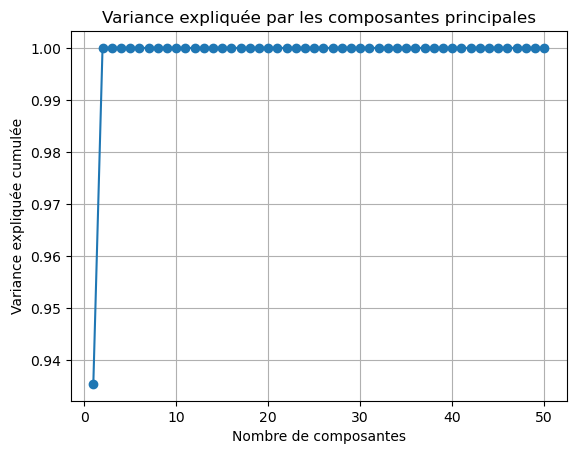

Précision : 0.4324

Rapport de classification :

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        30
     disgust       0.00      0.00      0.00         3
        fear       0.00      0.00      0.00         7
         joy       0.00      0.00      0.00        28
     neutral       0.44      0.97      0.60        97
     sadness       0.00      0.00      0.00        28
    surprise       0.67      0.07      0.12        29

    accuracy                           0.43       222
   macro avg       0.16      0.15      0.10       222
weighted avg       0.28      0.43      0.28       222



C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
import os
import re
import pandas as pd
import opensmile
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Chemin du dossier principal
dataset_path = "dataset_clean"

# Dossier à traiter (ici 'dev' uniquement pour tester la précision)
folder = "dev"

# Charger le CSV filtré avec les labels
csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
try:
    labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
except Exception as e:
    print(f"Erreur lors de la lecture de {csv_path} : {e}")

# Dossier des audios
audios_dir = os.path.join(dataset_path, folder, "audios")
if not os.path.exists(audios_dir):
    print(f"Le dossier des audios n'existe pas : {audios_dir}")

features_list = []

# Initialiser opensmile (ici avec ComParE_2016 et niveau Functionals)
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals
)

file_count = 0

# Parcourir les fichiers audio
for file in os.listdir(audios_dir):
    if file.lower().endswith(".wav"):
        audio_path = os.path.join(audios_dir, file)
        
        # Extraire dialogue_id et utterance_id à partir du nom de fichier
        match = re.match(r"dia(\d+)_utt(\d+)", file)
        if not match:
            print(f"Nom de fichier non conforme : {file}")
            continue
        dialogue_id = int(match.group(1))
        utterance_id = int(match.group(2))
        
        try:
            # Extraction des caractéristiques avec opensmile
            features_df = smile.process_file(audio_path)
        except Exception as e:
            print(f"Erreur lors de l'extraction pour {file} : {e}")
            continue

        # On récupère la première (et unique) ligne des features extraites
        feat_dict = features_df.iloc[0].to_dict()
        feat_dict["Dialogue_ID"] = dialogue_id
        feat_dict["Utterance_ID"] = utterance_id
        
        # Récupérer la label d'Emotion correspondant à ce fichier
        label_row = labels_df[
            (labels_df["Dialogue_ID"] == dialogue_id) & 
            (labels_df["Utterance_ID"] == utterance_id)
        ].iloc[0]  # On prend directement la première ligne correspondante

        feat_dict["Emotion"] = label_row["Emotion"]
        
        features_list.append(feat_dict)
        
        # Incrémenter le compteur
        file_count += 1

        # Afficher tous les 100 fichiers traités
        if file_count % 100 == 0:
            print(f"Progression : {file_count} fichiers traités")

# Créer un DataFrame avec toutes les caractéristiques
if not features_list:
    print(f"Aucun fichier audio traité dans {audios_dir}")

features_all = pd.DataFrame(features_list)

# Sélectionner les colonnes de features (exclure les colonnes non-numériques et le label Emotion)
exclude_cols = ["Dialogue_ID", "Utterance_ID", "Emotion"]
feature_cols = [col for col in features_all.columns if col not in exclude_cols]

X = features_all[feature_cols].values
y = features_all["Emotion"].values  # On utilise uniquement Emotion comme cible

# 1. Appliquer PCA pour réduire la dimensionnalité
pca = PCA(n_components=50)  # Tu peux ajuster le nombre de composantes
X_pca = pca.fit_transform(X)

# 2. Afficher la variance expliquée cumulée par les composantes principales
explained_variance = pca.explained_variance_ratio_

# Tracer la courbe de variance expliquée
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par les composantes principales")
plt.grid(True)
plt.show()

# 3. Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 4. Entraîner un modèle de classification (ici RandomForestClassifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Prédiction et évaluation sur l'ensemble de test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision : {accuracy:.4f}")
print("\nRapport de classification :\n")
print(classification_report(y_test, y_pred))


In [7]:
import os
import re
import pandas as pd
import opensmile
from sklearn.decomposition import PCA

# Chemin du dossier principal
dataset_path = "dataset_clean"

# Dossiers à traiter
folders = ["dev", "train", "test"]

# Pour chaque dossier
for folder in folders:
    print(f"\nTraitement du dossier {folder}...")
    
    # Charger le CSV filtré avec les labels
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lors de la lecture de {csv_path} : {e}")
        continue

    # Dossier des audios
    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Le dossier des audios n'existe pas : {audios_dir}")
        continue

    features_list = []

    # Initialiser opensmile (ici avec ComParE_2016 et niveau Functionals)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals
    )
    
    file_count = 0
    
    # Parcourir les fichiers audio
    for file in os.listdir(audios_dir):
        if file.lower().endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            
            # Extraire dialogue_id et utterance_id à partir du nom de fichier
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                print(f"Nom de fichier non conforme : {file}")
                continue
            dialogue_id = int(match.group(1))
            utterance_id = int(match.group(2))
            
            try:
                # Extraction des caractéristiques avec opensmile
                features_df = smile.process_file(audio_path)
            except Exception as e:
                print(f"Erreur lors de l'extraction pour {file} : {e}")
                continue

            # On récupère la première (et unique) ligne des features extraites
            feat_dict = features_df.iloc[0].to_dict()
            feat_dict["Dialogue_ID"] = dialogue_id
            feat_dict["Utterance_ID"] = utterance_id
            
            # Récupérer le label d'Emotion correspondant à ce fichier
            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dialogue_id) & 
                (labels_df["Utterance_ID"] == utterance_id)
            ].iloc[0]  # On prend directement la première ligne correspondante

            feat_dict["Emotion"] = label_row["Emotion"]
            
            features_list.append(feat_dict)
            
            # Incrémenter le compteur
            file_count += 1

            # Afficher tous les 100 fichiers traités
            if file_count % 100 == 0:
                print(f"Progression : {file_count} fichiers traités")
    
    # Créer un DataFrame avec toutes les caractéristiques
    if not features_list:
        print(f"Aucun fichier audio traité dans {audios_dir}")
        continue
    features_all = pd.DataFrame(features_list)
    
    # Sélectionner les colonnes de features (exclure les colonnes non-numériques et le label Emotion)
    exclude_cols = ["Dialogue_ID", "Utterance_ID", "Emotion"]
    feature_cols = [col for col in features_all.columns if col not in exclude_cols]
    
    X = features_all[feature_cols].values
    y = features_all["Emotion"].values  # On utilise uniquement Emotion comme cible

    # Appliquer PCA avec n_components=2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # 3. Ajouter les composantes PCA réduites au DataFrame
    for i in range(X_pca.shape[1]):
        features_all[f"PCA_{i+1}"] = X_pca[:, i]

    # 4. Filtrer les colonnes pour ne garder que les caractéristiques PCA (et Emotion)
    columns_to_keep = ["Emotion"] + [f"PCA_{i+1}" for i in range(X_pca.shape[1])]
    features_all = features_all[columns_to_keep]

    # 5. Enregistrer le DataFrame avec les caractéristiques dans un CSV
    output_csv = os.path.join(dataset_path, folder, f"features_{folder}_pca.csv")
    features_all.to_csv(output_csv, index=False)
    print(f"Fichier des caractéristiques PCA sauvegardé : {output_csv}")



Traitement du dossier dev...
Progression : 100 fichiers traités
Progression : 200 fichiers traités
Progression : 300 fichiers traités
Progression : 400 fichiers traités
Progression : 500 fichiers traités
Progression : 600 fichiers traités
Progression : 700 fichiers traités
Progression : 800 fichiers traités
Progression : 900 fichiers traités
Progression : 1000 fichiers traités
Progression : 1100 fichiers traités
Fichier des caractéristiques PCA sauvegardé : dataset_clean\dev\features_dev_pca.csv

Traitement du dossier train...
Progression : 100 fichiers traités
Progression : 200 fichiers traités
Progression : 300 fichiers traités
Progression : 400 fichiers traités
Progression : 500 fichiers traités
Progression : 600 fichiers traités
Progression : 700 fichiers traités
Progression : 800 fichiers traités
Progression : 900 fichiers traités
Progression : 1000 fichiers traités
Progression : 1100 fichiers traités
Progression : 1200 fichiers traités
Progression : 1300 fichiers traités
Progres

In [2]:
import os
import re
import pandas as pd
import numpy as np
import opensmile
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Chemin du dataset
dataset_path = "dataset_clean"
folders = ["train", "dev", "test"]

# Stocker les features bruts + labels pour chaque split
all_data = {}

# --- 1. Extraction avec OpenSMILE ---
for folder in folders:
    print(f"\n🔍 Traitement du dossier : {folder}")
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lecture CSV : {e}")
        continue

    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Dossier audio introuvable : {audios_dir}")
        continue

    features_list = []
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals
    )

    file_count = 0  # Compteur de fichiers traités
    total_files = len([f for f in os.listdir(audios_dir) if f.endswith(".wav")])  # Nombre total de fichiers

    for file in os.listdir(audios_dir):
        if file.endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                continue
            dia_id = int(match.group(1))
            utt_id = int(match.group(2))

            try:
                feats_df = smile.process_file(audio_path)
            except Exception as e:
                print(f"Erreur OpenSMILE sur {file} : {e}")
                continue

            feat_dict = feats_df.iloc[0].to_dict()
            feat_dict["Dialogue_ID"] = dia_id
            feat_dict["Utterance_ID"] = utt_id

            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dia_id) & 
                (labels_df["Utterance_ID"] == utt_id)
            ]
            if label_row.empty:
                continue

            label_row = label_row.iloc[0]
            feat_dict["Emotion"] = label_row["Emotion"]
            feat_dict["Sentiment"] = label_row["Sentiment"]
            feat_dict["Label"] = f"{label_row['Emotion']}_{label_row['Sentiment']}"

            features_list.append(feat_dict)

        file_count += 1

        # Afficher la progression tous les 100 fichiers
        if file_count % 100 == 0 or file_count == total_files:
            print(f"Traitement des fichiers : {file_count}/{total_files} fichiers traités")

    if not features_list:
        print(f"Aucun fichier audio traité dans {folder}")
        continue

    df = pd.DataFrame(features_list)
    all_data[folder] = df

# --- 2. Scaler + PCA ---
print("\n⚙️ Prétraitement : StandardScaler + PCA (95%)")
exclude = ["Dialogue_ID", "Utterance_ID", "Emotion", "Sentiment", "Label"]
feature_cols = [col for col in all_data["train"].columns if col not in exclude]

# Fit scaler et PCA uniquement sur TRAIN
X_train = all_data["train"][feature_cols].values
y_train = all_data["train"]["Label"].values

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

pca = PCA(n_components=0.95).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

# On ajoute au dataframe
for i in range(X_train_pca.shape[1]):
    all_data["train"][f"PCA_{i+1}"] = X_train_pca[:, i]

# --- 3. Appliquer transform sur dev et test ---
for split in ["dev", "test"]:
    if split not in all_data:
        continue
    X_split = all_data[split][feature_cols].values
    X_scaled = scaler.transform(X_split)
    X_pca = pca.transform(X_scaled)

    for i in range(X_pca.shape[1]):
        all_data[split][f"PCA_{i+1}"] = X_pca[:, i]

# --- 4. Sauvegarde des CSV PCA ---
for split in all_data:
    df = all_data[split]
    pca_cols = [col for col in df.columns if col.startswith("PCA_")]
    output_df = df[["Emotion"] + pca_cols]
    output_path = os.path.join(dataset_path, split, f"features_{split}_pca2.csv")
    output_df.to_csv(output_path, index=False)
    print(f"✅ Sauvegardé : {output_path}")



🔍 Traitement du dossier : train
Traitement des fichiers : 100/9988 fichiers traités


KeyboardInterrupt: 

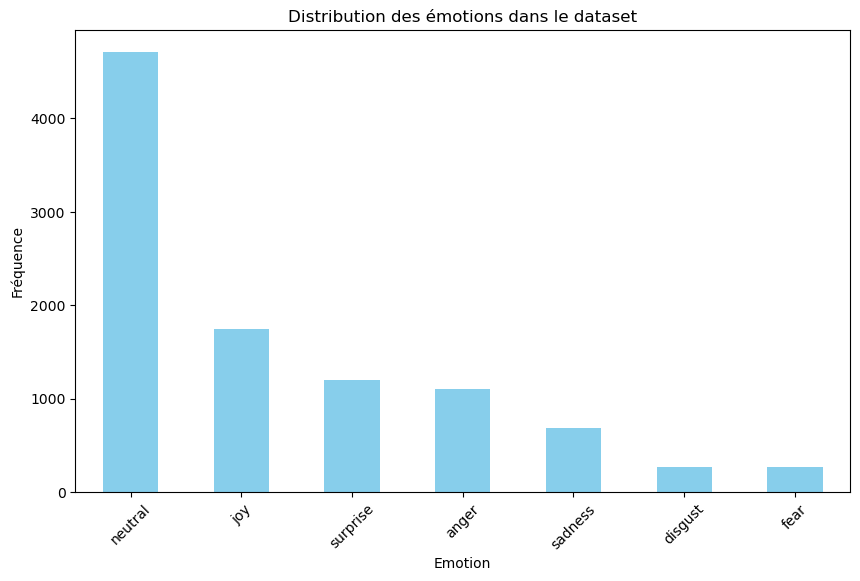

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger ton fichier CSV contenant les émotions
csv_path = "dataset_clean/train/filtered_train_sent_emo.csv"  # Change ce chemin en fonction de ton dataset
df = pd.read_csv(csv_path, encoding="ISO-8859-1")

# Visualiser la distribution des émotions
plt.figure(figsize=(10, 6))
df['Emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution des émotions dans le dataset')
plt.xlabel('Emotion')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.show()


In [5]:
import os
import re
import opensmile
import pandas as pd

# Chemin du dataset
dataset_path = "dataset_clean"
folders = ["train", "dev", "test"]

# Dictionnaire pour stocker les données traitées
all_data = {}

for folder in folders:
    print(f"\n🔍 Traitement du dossier : {folder}")
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lecture CSV : {e}")
        continue

    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Dossier audio introuvable : {audios_dir}")
        continue

    features_list = []
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals
    )

    total_files = len([f for f in os.listdir(audios_dir) if f.endswith(".wav")])
    file_count = 0  # Compteur des fichiers traités

    for file in os.listdir(audios_dir):
        if file.endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                continue
            dia_id = int(match.group(1))
            utt_id = int(match.group(2))

            try:
                feats_df = smile.process_file(audio_path)
            except Exception as e:
                print(f"Erreur OpenSMILE sur {file} : {e}")
                continue

            feat_dict = feats_df.iloc[0].to_dict()
            feat_dict["Dialogue_ID"] = dia_id
            feat_dict["Utterance_ID"] = utt_id

            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dia_id) & 
                (labels_df["Utterance_ID"] == utt_id)
            ]
            if label_row.empty:
                continue

            label_row = label_row.iloc[0]
            feat_dict["Emotion"] = label_row["Emotion"]
            feat_dict["Sentiment"] = label_row["Sentiment"]
            feat_dict["Label"] = f"{label_row['Emotion']}_{label_row['Sentiment']}"

            features_list.append(feat_dict)

        # Affichage de la progression tous les 100 fichiers
        file_count += 1
        if file_count % 100 == 0:
            print(f"Traitement des fichiers : {file_count}/{total_files}")

    if features_list:
        df = pd.DataFrame(features_list)
        all_data[folder] = df




🔍 Traitement du dossier : train
Traitement des fichiers : 100/9988


KeyboardInterrupt: 

In [ ]:
import os
import re
import opensmile
import pandas as pd

# Chemin du dataset
dataset_path = "dataset_clean"
folders = ["train", "dev", "test"]

# Dictionnaire pour stocker les données traitées
all_data = {}

for folder in folders:
    print(f"\n🔍 Traitement du dossier : {folder}")
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lecture CSV : {e}")
        continue

    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Dossier audio introuvable : {audios_dir}")
        continue

    features_list = []
    
    # Utiliser GeMAPSv01b à la place de GeMAPSv01a
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.GeMAPSv01b,  # Changer ici pour GeMAPSv01b
        feature_level=opensmile.FeatureLevel.Functionals
    )

    total_files = len([f for f in os.listdir(audios_dir) if f.endswith(".wav")])
    file_count = 0  # Compteur des fichiers traités

    for file in os.listdir(audios_dir):
        if file.endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                continue
            dia_id = int(match.group(1))
            utt_id = int(match.group(2))
            try:
                feats_df = smile.process_file(audio_path)
            except Exception as e:
                print(f"Erreur OpenSMILE sur {file} : {e}")
                continue
            feat_dict = feats_df.iloc[0].to_dict()
            feat_dict["Dialogue_ID"] = dia_id
            feat_dict["Utterance_ID"] = utt_id

            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dia_id) & 
                (labels_df["Utterance_ID"] == utt_id)
            ]
            if label_row.empty:
                continue

            label_row = label_row.iloc[0]
            feat_dict["Emotion"] = label_row["Emotion"]
            feat_dict["Sentiment"] = label_row["Sentiment"]
            feat_dict["Label"] = f"{label_row['Emotion']}_{label_row['Sentiment']}"

            features_list.append(feat_dict)

        # Affichage de la progression tous les 100 fichiers
        file_count += 1
        if file_count % 100 == 0:
            print(f"Traitement des fichiers : {file_count}")

    if features_list:
        df = pd.DataFrame(features_list)
        all_data[folder] = df



🔍 Traitement du dossier : train
Traitement des fichiers : 10/9988
Traitement des fichiers : 20/9988
Traitement des fichiers : 30/9988
Traitement des fichiers : 40/9988


Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x0000023763AABF60>
Traceback (most recent call last):
  File "C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\lib.py", line 458, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):

KeyboardInterrupt: 
C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\smile.py:297: UserWarning: Segment too short, filling with NaN.
  warnings.warn(UserWarning("Segment too short, filling with NaN."))


Traitement des fichiers : 50/9988
Traitement des fichiers : 60/9988
Traitement des fichiers : 70/9988
Traitement des fichiers : 80/9988


Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x0000023763AA8540>
Traceback (most recent call last):
  File "C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\lib.py", line 458, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):

KeyboardInterrupt: 
C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\smile.py:297: UserWarning: Segment too short, filling with NaN.
  warnings.warn(UserWarning("Segment too short, filling with NaN."))


Traitement des fichiers : 90/9988
Traitement des fichiers : 100/9988
Traitement des fichiers : 110/9988
Traitement des fichiers : 120/9988
Traitement des fichiers : 130/9988


Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x0000023763AA8540>
Traceback (most recent call last):
  File "C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\lib.py", line 458, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):

KeyboardInterrupt: 
C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\smile.py:297: UserWarning: Segment too short, filling with NaN.
  warnings.warn(UserWarning("Segment too short, filling with NaN."))


Traitement des fichiers : 140/9988
Traitement des fichiers : 150/9988
Traitement des fichiers : 160/9988
Traitement des fichiers : 170/9988
Traitement des fichiers : 180/9988
Traitement des fichiers : 190/9988
Traitement des fichiers : 200/9988


Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x0000023763AC0040>
Traceback (most recent call last):
  File "C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\lib.py", line 458, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):

KeyboardInterrupt: 
C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\smile.py:297: UserWarning: Segment too short, filling with NaN.
  warnings.warn(UserWarning("Segment too short, filling with NaN."))
Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x0000023763AC3E20>
Traceback (most recent call last):
  File "C:\Users\boucceredj\anaconda3\Lib\site-packages\opensmile\core\lib.py", line 458, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):

KeyboardInterrup

Traitement des fichiers : 210/9988
Traitement des fichiers : 220/9988
Traitement des fichiers : 230/9988


In [6]:
!pip install librosa --user

  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/b5/ba/c63c5786dfee4c3417094c4b00966e61e4a63efecee22cb7b4c0387dda83/librosa-0.11.0-py3-none-any.whl.metadata
  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Obtaining dependency information for audioread>=2.1.9 from https://files.pythonhosted.org/packages/57/8d/30aa32745af16af0a9a650115fbe81bde7c610ed5c21b381fca0196f3a7f/audioread-3.0.1-py3-none-any.whl.metadata
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Obtaining dependency information for pooch>=1.1 from https://files.pythonhosted.org/packages/a8/87/77cc11c7a9ea9fd05503def69e3d18605852cd0d4b0d3b8f15bbeb3ef1d1/pooch-1.8.2-py3-none-any.whl.metadata
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for soxr>=0.3.2 from https://files.pythonhosted.org/packages/86/94/6a7e91bea7e6ca193ee429869b8f18548cd79759e064021ecb5756024c7c/soxr-0.5.0.post1-cp311-cp311-win_am

In [2]:
import os
import re
import librosa
import pandas as pd

# Chemin du dataset
dataset_path = "dataset_clean"
folders = ["train", "dev", "test"]

# Dictionnaire pour stocker les données traitées
all_data = {}

for folder in folders:
    print(f"\n🔍 Traitement du dossier : {folder}")
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lecture CSV : {e}")
        continue

    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Dossier audio introuvable : {audios_dir}")
        continue

    features_list = []

    total_files = len([f for f in os.listdir(audios_dir) if f.endswith(".wav")])
    file_count = 0  # Compteur des fichiers traités

    for file in os.listdir(audios_dir):
        if file.endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                continue
            dia_id = int(match.group(1))
            utt_id = int(match.group(2))

            try:
                # Charger l'audio
                y, sr = librosa.load(audio_path, sr=None)
                # Extraire des caractéristiques (par exemple, MFCC)
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                features = mfccs.mean(axis=1)  # Moyenne des MFCCs
            except Exception as e:
                print(f"Erreur Librosa sur {file} : {e}")
                continue

            feat_dict = {f"MFCC_{i+1}": features[i] for i in range(len(features))}
            feat_dict["Dialogue_ID"] = dia_id
            feat_dict["Utterance_ID"] = utt_id

            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dia_id) & 
                (labels_df["Utterance_ID"] == utt_id)
            ]
            if label_row.empty:
                continue

            label_row = label_row.iloc[0]
            feat_dict["Emotion"] = label_row["Emotion"]
            feat_dict["Sentiment"] = label_row["Sentiment"]
            feat_dict["Label"] = f"{label_row['Emotion']}_{label_row['Sentiment']}"

            features_list.append(feat_dict)

        # Affichage de la progression tous les 100 fichiers
        file_count += 1
        if file_count % 100 == 0:
            print(f"Traitement des fichiers : {file_count}")

    if features_list:
        df = pd.DataFrame(features_list)
        all_data[folder] = df



🔍 Traitement du dossier : train


C:\Users\boucceredj\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


KeyboardInterrupt: 

In [11]:
!pip install --upgrade imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/9d/41/721fec82606242a2072ee909086ff918dfad7d0199a9dfd4928df9c72494/imbalanced_learn-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for sklearn-compat<1,>=0.1 from https://files.pythonhosted.org/packages/f0/a8/ad69cf130fbd017660cdd64abbef3f28135d9e2e15fe3002e03c5be0ca38/sklearn_compat-0.1.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/238.4 kB ? eta -:--:--
   -------------------- ------------------- 122.9/238.4 kB 2.4 MB/s eta 0:00:01
   ---------------------------------- ----- 204.8/238.4 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------  235.5/238.4 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------  235.5/238.4 kB 2.4 MB/s eta 0:00:01
   -------------------------------------- 238.4/238.4 kB 970.8 kB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import collections

# 👇 Si tu viens de ton script d’extraction
# all_data = {"train": df_train, "dev": df_dev, "test": df_test}

# 1. Fusion des données
combined_df = pd.concat(all_data.values(), ignore_index=True)

# 2. Sélection des features MFCC
feature_cols = [f"MFCC_{i+1}" for i in range(13)]
X = combined_df[feature_cols].values
y = combined_df["Label"].values  # ou "Label" si tu veux utiliser emotion + sentiment

# 3. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split train/test (tu peux aussi faire train=all_data["train"], test=all_data["test"] si tu veux garder la logique de split par fichier)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 5. Oversampling (Random Over Sampling pour équilibrer les classes)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Affichage de la répartition des classes avant et après oversampling
print("Avant oversampling:", collections.Counter(y_train))
print("Après oversampling:", collections.Counter(y_train_resampled))

# 6. Liste des modèles à tester
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naïve Bayes": GaussianNB(),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
}

# 7. Tester les modèles
best_model = None
best_accuracy = 0

for name, model in models.items():
    print(f"\n🔍 Test du modèle : {name}")
    
    # Entraînement sur les données oversamplées
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"🎯 Précision : {acc:.4f}")

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = (name, model)

    print("📊 Rapport de classification :\n")
    print(classification_report(y_test, y_pred))

# 8. Résumé
print("\n✅ Meilleur modèle :", best_model[0])
print(f"🎯 Meilleure précision : {best_accuracy:.4f}")


NameError: name 'all_data' is not defined

In [ ]:
print(combined_df["Label"].value_counts())

In [15]:
# Code updated to remove the tonnetz feature

import os
import re
import librosa
import pandas as pd

# Chemin du dataset
dataset_path = "dataset_clean"
folders = ["train", "dev", "test"]

# Dictionnaire pour stocker les données traitées
all_data = {}

for folder in folders:
    print(f"\n🔍 Traitement du dossier : {folder}")
    csv_path = os.path.join(dataset_path, folder, f"filtered_{folder}_sent_emo.csv")
    
    try:
        labels_df = pd.read_csv(csv_path, encoding="ISO-8859-1")
    except Exception as e:
        print(f"Erreur lecture CSV : {e}")
        continue

    audios_dir = os.path.join(dataset_path, folder, "audios")
    if not os.path.exists(audios_dir):
        print(f"Dossier audio introuvable : {audios_dir}")
        continue

    features_list = []

    total_files = len([f for f in os.listdir(audios_dir) if f.endswith(".wav")])
    file_count = 0  # Compteur des fichiers traités

    for file in os.listdir(audios_dir):
        if file.endswith(".wav"):
            audio_path = os.path.join(audios_dir, file)
            match = re.match(r"dia(\d+)_utt(\d+)", file)
            if not match:
                continue
            dia_id = int(match.group(1))
            utt_id = int(match.group(2))

            try:
                # Charger l'audio
                y, sr = librosa.load(audio_path, sr=None)
                
                # Extraire les caractéristiques audio
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=256)
                spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=256)
                zcr = librosa.feature.zero_crossing_rate(y=y)
                rmse = librosa.feature.rms(y=y)

                # Calculer les moyennes pour chaque caractéristique
                features = {
                    **{f"MFCC_{i+1}": mfccs[i].mean() for i in range(13)},
                    **{f"Chroma_{i+1}": chroma[i].mean() for i in range(12)},
                    "Spectral_Rolloff": spectral_rolloff.mean(),
                    "Zero_Crossing_Rate": zcr.mean(),
                    "RMSE": rmse.mean(),
                }
                
            except Exception as e:
                print(f"Erreur Librosa sur {file} : {e}")
                continue

            feat_dict = {**features, "Dialogue_ID": dia_id, "Utterance_ID": utt_id}

            label_row = labels_df[
                (labels_df["Dialogue_ID"] == dia_id) & 
                (labels_df["Utterance_ID"] == utt_id)
            ]
            if label_row.empty:
                continue

            label_row = label_row.iloc[0]
            feat_dict["Emotion"] = label_row["Emotion"]
            feat_dict["Sentiment"] = label_row["Sentiment"]
            feat_dict["Label"] = f"{label_row['Emotion']}_{label_row['Sentiment']}" 

            features_list.append(feat_dict)

        # Affichage de la progression tous les 100 fichiers
        file_count += 1
        if file_count % 100 == 0:
            print(f"Traitement des fichiers : {file_count}")

    if features_list:
        df = pd.DataFrame(features_list)
        all_data[folder] = df
        
        # Sauvegarder dans un fichier CSV
        output_csv = os.path.join(dataset_path, folder, f"features_{folder}_librosa.csv")
        df.to_csv(output_csv, index=False)
        print(f"Fichier des caractéristiques sauvegardé : {output_csv}")



🔍 Traitement du dossier : train
Traitement des fichiers : 100
Traitement des fichiers : 200
Traitement des fichiers : 300
Traitement des fichiers : 400
Traitement des fichiers : 500
Traitement des fichiers : 600
Traitement des fichiers : 700
Traitement des fichiers : 800
Traitement des fichiers : 900
Traitement des fichiers : 1000
Traitement des fichiers : 1100
Traitement des fichiers : 1200
Traitement des fichiers : 1300
Traitement des fichiers : 1400
Traitement des fichiers : 1500
Traitement des fichiers : 1600
Traitement des fichiers : 1700
Traitement des fichiers : 1800
Traitement des fichiers : 1900
Traitement des fichiers : 2000
Traitement des fichiers : 2100
Traitement des fichiers : 2200
Traitement des fichiers : 2300
Traitement des fichiers : 2400
Traitement des fichiers : 2500
Traitement des fichiers : 2600
Traitement des fichiers : 2700
Traitement des fichiers : 2800
Traitement des fichiers : 2900
Traitement des fichiers : 3000
Traitement des fichiers : 3100
Traitement des 